In [1]:
import numpy as np
from pyscf import fci
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Optional, Union, Callable, cast
plt.rcParams.update(plt.rcParamsDefault)

import qulacs
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CZ, RY, RZ, merge
from qulacsvis import circuit_drawer

from openfermion.chem import MolecularData
from openfermionpsi4 import run_psi4
from openfermionpyscf import run_pyscf
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator

from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance
from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule, QMolecule
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper
from qiskit_nature.circuit.library import HartreeFock, UCC, UCCSD
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.algorithms import VQEUCCFactory
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SLSQP

In [2]:
class Molecular_Exact():

    def __init__(self):
        # H2
        self.molecule_name = "H .0 .0 .0; H .0 .0 "
        self.backend = QuantumInstance(backend=Aer.get_backend("statevector_simulator"))
        self.optimizer = SLSQP(maxiter=5)
        
        
    def get_qubit_op(self, dist, mapper='jw'):
        driver = PySCFDriver(atom=self.molecule_name + str(dist), unit=UnitsType.ANGSTROM,
                             charge=0, spin=0, basis='sto3g')
        molecule = driver.run()
        es_problem = ElectronicStructureProblem(driver)

        if mapper == 'jw':
            qubit_converter = QubitConverter(mapper=JordanWignerMapper())
        elif mapper == 'parity':
            qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)

        return es_problem, qubit_converter, molecule.nuclear_repulsion_energy
        
        
    def run(self):

        numpy_solver = NumPyMinimumEigensolver()
        distances = np.arange(0.35, 3.0, 0.2)
        exact_energies = []

        n = len(distances)
        i = 1

        for dist in distances:
            print("Distance %d/%d" % (i, n))
            i += 1

            es_problem, qubit_converter, nuclear_repulsion_energy = self.get_qubit_op(dist)
            second_q_ops = es_problem.second_q_ops()

            main_op = qubit_converter.convert(second_q_ops[0],
                                              num_particles=es_problem.num_particles,
                                              sector_locator=es_problem.symmetry_sector_locator)

            print("Calculating min eigenvalue...")

            exact_result = numpy_solver.compute_minimum_eigenvalue(main_op)
            exact_energies.append(np.real(exact_result.eigenvalue) + nuclear_repulsion_energy)
            print("Bond length (A):", np.round(dist, 1), "Energy (Hartree):", exact_energies[-1])

        return (distances, exact_energies)

In [3]:
exact = Molecular_Exact()
res = exact.run()

Distance 1/14
Calculating min eigenvalue...
Bond length (A): 0.4 Energy (Hartree): -0.7892693924044119
Distance 2/14


/var/folders/29/lky49h8n0db31xnyhhbfqxkw0000gp/T/ipykernel_16435/610625779.py:11: DeprecationWarning: The PySCFDriver class is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the PySCFDriver class from qiskit_nature.drivers.second_quantization.pyscfd.
  driver = PySCFDriver(atom=self.molecule_name + str(dist), unit=UnitsType.ANGSTROM,


Calculating min eigenvalue...
Bond length (A): 0.6 Energy (Hartree): -1.0926299067451013
Distance 3/14
Calculating min eigenvalue...
Bond length (A): 0.8 Energy (Hartree): -1.137117067345731
Distance 4/14
Calculating min eigenvalue...
Bond length (A): 1.0 Energy (Hartree): -1.1113394177361504
Distance 5/14
Calculating min eigenvalue...
Bond length (A): 1.2 Energy (Hartree): -1.0679296589128595
Distance 6/14
Calculating min eigenvalue...
Bond length (A): 1.4 Energy (Hartree): -1.025054362468786
Distance 7/14
Calculating min eigenvalue...
Bond length (A): 1.6 Energy (Hartree): -0.9904763409366248
Distance 8/14
Calculating min eigenvalue...
Bond length (A): 1.8 Energy (Hartree): -0.9663345447803081
Distance 9/14
Calculating min eigenvalue...
Bond length (A): 2.0 Energy (Hartree): -0.9512897588020859
Distance 10/14
Calculating min eigenvalue...
Bond length (A): 2.2 Energy (Hartree): -0.942677785696274
Distance 11/14
Calculating min eigenvalue...
Bond length (A): 2.4 Energy (Hartree): -0.93

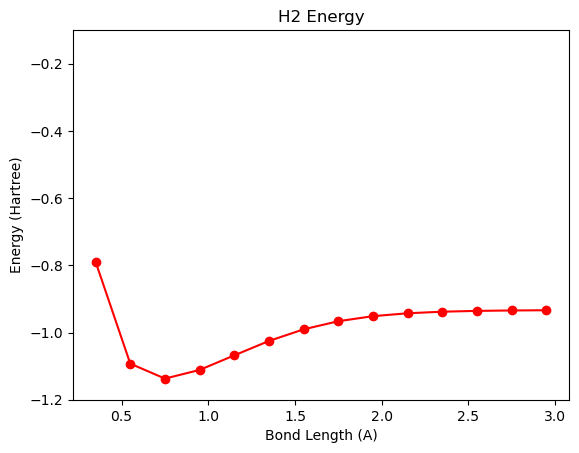


------ Ground State Energy and corresponding Bond Length ----- 

Bond Length (A): 0.750000
Energy (Hatree): -1.137117


In [4]:
plt.plot(res[0], res[1], c='r', marker="o", linestyle="-", label='Exact')

plt.title('H2 Energy')
plt.ylabel('Energy (Hartree)')
plt.xlabel('Bond Length (A)')
plt.ylim(-1.2, -0.1)
plt.show()


# Output the found ground state energy and corresponding bond length
print("\n------ Ground State Energy and corresponding Bond Length ----- \n")
idx = res[1].index(min(res[1]))
dist, min_energy = res[0][res[1].index(min(res[1]))], min(res[1])
print("Bond Length (A): %f" % dist)
print("Energy (Hatree): %f" % min_energy)

----

In [5]:
# Set molecule parameters.
bond_length_interval = 0.11
n_points = 30

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for point in range(3, n_points + 1):
    bond_length = bond_length_interval * float(point)
    bond_lengths += [bond_length]
    molecule = MolecularData( [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))], basis='sto-3g', multiplicity=1,
        description=str(round(bond_length, 2)))
    
    # Run Psi4.
    molecule = run_psi4(molecule,
                        run_scf=1,
                        run_mp2=0,
                        run_cisd=0,
                        run_ccsd=0,
                        run_fci=1)

    # Print out some results of calculation.
    print('\nAt bond length of {} angstrom, molecular hydrogen has:'.format(bond_length))
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
    print('FCI energy of {} Hartree.'.format(molecule.fci_energy))
    print('Nuclear repulsion energy between protons is {} Hartree.'.format(molecule.nuclear_repulsion))
    
    for orbital in range(molecule.n_orbitals):
        print('Spatial orbital {} has energy of {} Hartree.'.format(
            orbital, molecule.orbital_energies[orbital]))
        
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]


At bond length of 0.33 angstrom, molecular hydrogen has:
Hartree-Fock energy of -0.7150099138652936 Hartree.
FCI energy of -0.7234729792447299 Hartree.
Nuclear repulsion energy between protons is 1.603567305060606 Hartree.
Spatial orbital 0 has energy of -0.7854135125918265 Hartree.
Spatial orbital 1 has energy of 1.3069119070626702 Hartree.

At bond length of 0.44 angstrom, molecular hydrogen has:
Hartree-Fock energy of -0.9734275527207122 Hartree.
FCI energy of -0.984095657993449 Hartree.
Nuclear repulsion energy between protons is 1.2026754787954546 Hartree.
Spatial orbital 0 has energy of -0.7229507578088632 Hartree.
Spatial orbital 1 has energy of 1.0926562085671585 Hartree.

At bond length of 0.55 angstrom, molecular hydrogen has:
Hartree-Fock energy of -1.0790507363246538 Hartree.
FCI energy of -1.092629906900074 Hartree.
Nuclear repulsion energy between protons is 0.9621403830363635 Hartree.
Spatial orbital 0 has energy of -0.6652813913317516 Hartree.
Spatial orbital 1 has ene

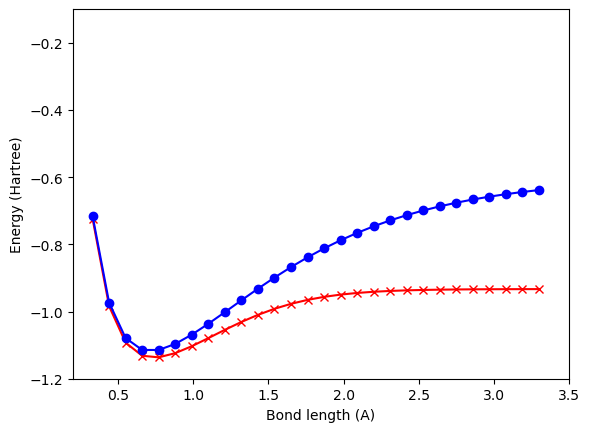

In [6]:
plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'x-', color="red", label="Exact FCI")
plt.plot(bond_lengths, hf_energies, 'o-', color="blue", label="HF")
plt.ylabel('Energy (Hartree)')
plt.xlabel('Bond length (A)')
plt.ylim(-1.2, -0.1)
plt.xlim(0.2, 3.5)
plt.show()

-------

# Construct the Clifford Ansatz

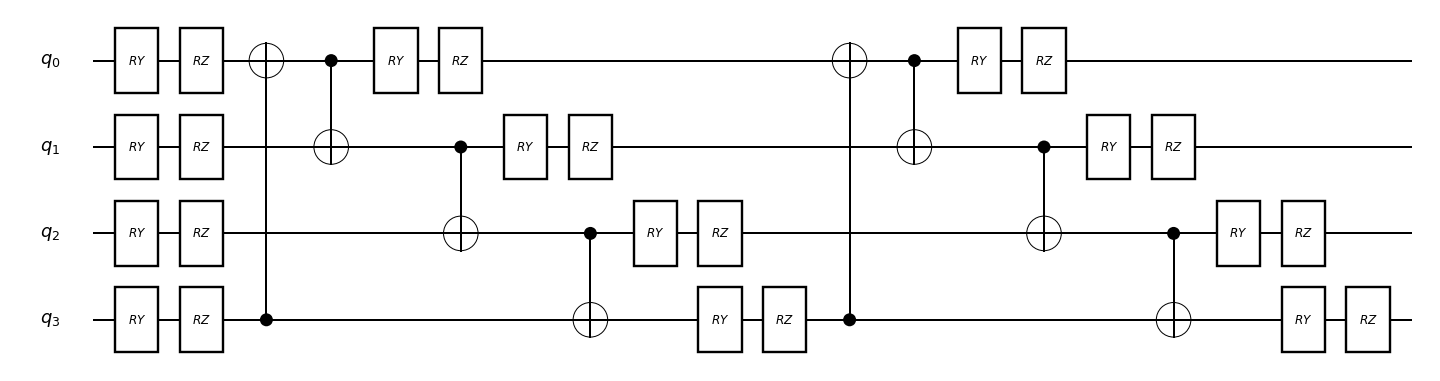

In [7]:
n_qubit = 4
depth = 2
theta_list = np.random.random(2*n_qubit*(depth+1))*1e-1

circuit = QuantumCircuit(n_qubit)
for i in range(n_qubit):
    circuit.add_gate(RY(i, theta_list[2*i+2*n_qubit]))
    
for i in range(n_qubit):
    circuit.add_gate(RZ(i, theta_list[2*i+2*n_qubit]))
    
circuit.add_CNOT_gate(n_qubit-1, 0)

for i in range(n_qubit -1):
    circuit.add_CNOT_gate(i, i+1)
    circuit.add_gate(RY(i, theta_list[2*i+2*n_qubit]))
    circuit.add_gate(RZ(i, theta_list[2*i+2*n_qubit]))

circuit.add_gate(RY(n_qubit-1, theta_list[2*i+2*n_qubit]))
circuit.add_gate(RZ(n_qubit-1, theta_list[2*i+2*n_qubit]))

circuit.add_CNOT_gate(n_qubit-1, 0)

for i in range(n_qubit -1):
    circuit.add_CNOT_gate(i, i+1)
    circuit.add_gate(RY(i, theta_list[2*i+2*n_qubit]))
    circuit.add_gate(RZ(i, theta_list[2*i+2*n_qubit]))

circuit.add_gate(RY(n_qubit-1, theta_list[2*i+2*n_qubit]))
circuit.add_gate(RZ(n_qubit-1, theta_list[2*i+2*n_qubit]))
      
circuit_drawer(circuit, "mpl")

-------

In [8]:
basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.977
geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
description  = "tmp"
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

In [9]:
print(geometry)
print("---------------------------")
print(molecule)
print("---------------------------")
print(n_qubit)
print("---------------------------")
print(n_electron)
print("---------------------------")
print(fermionic_hamiltonian)
print("---------------------------")
print(jw_hamiltonian)

[['H', [0, 0, 0]], ['H', [0, 0, 0.977]]]
---------------------------
---------------------------
4
---------------------------
2
---------------------------
0.5416348115864893 [] +
-1.122302133307056 [0^ 0] +
0.31525261103166835 [0^ 0^ 0 0] +
0.0976694527308129 [0^ 0^ 2 2] +
0.31525261103166835 [0^ 1^ 1 0] +
0.0976694527308129 [0^ 1^ 3 2] +
0.0976694527308129 [0^ 2^ 0 2] +
0.3125771045578729 [0^ 2^ 2 0] +
0.0976694527308129 [0^ 3^ 1 2] +
0.3125771045578729 [0^ 3^ 3 0] +
0.31525261103166835 [1^ 0^ 0 1] +
0.0976694527308129 [1^ 0^ 2 3] +
-1.122302133307056 [1^ 1] +
0.31525261103166835 [1^ 1^ 1 1] +
0.0976694527308129 [1^ 1^ 3 3] +
0.0976694527308129 [1^ 2^ 0 3] +
0.3125771045578729 [1^ 2^ 2 1] +
0.0976694527308129 [1^ 3^ 1 3] +
0.3125771045578729 [1^ 3^ 3 1] +
0.3125771045578729 [2^ 0^ 0 2] +
0.0976694527308129 [2^ 0^ 2 0] +
0.3125771045578729 [2^ 1^ 1 2] +
0.0976694527308129 [2^ 1^ 3 0] +
-0.5821326565310088 [2^ 2] +
0.0976694527308129 [2^ 2^ 0 0] +
0.32838580201973205 [2^ 2^ 2 2] +
0.0